In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
mnist = input_data.read_data_sets('MNIST_data')
input_size = 784
num_digits = 10

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
params = {
    'e_layers': [128],
    'd_layers': [128],
    'digit_layers': [128],
    'd_std': 0.5,
    'z_dim': 10,
    'activation': tf.nn.sigmoid,
    'batch_size': 100,
    'epochs': 20,
    'learning_rate': 0.001,
    'digit_classifier_weight': 10
}

In [4]:
def encoder(x, layers):
    for layer in layers:
        x = tf.layers.dense(x, layer, activation=params['activation'])
    mu = tf.layers.dense(x, params['z_dim'])
    var = 1e-5 + tf.exp(tf.layers.dense(x, params['z_dim']))
    return mu, var


def decoder(z, layers):
    for layer in layers:
        z = tf.layers.dense(z, layer, activation=params['activation'])
    mu = tf.layers.dense(z, input_size)
    return tf.nn.sigmoid(mu)


def digit_classifier(x, layers):
    for layer in layers:
        x = tf.layers.dense(x, layer, activation=params['activation'])
    logits = tf.layers.dense(x, num_digits)
    return logits

In [5]:
images = tf.placeholder(tf.float32, [None, input_size])
digits = tf.placeholder(tf.int32, [None])
e_mu, e_var = encoder(images, params['e_layers'])
eps = tf.random_normal([tf.shape(images)[0], params['z_dim']], mean=0.0, stddev=1.0)
z = e_mu + tf.sqrt(e_var) * eps
digit_logits = digit_classifier(images, params['digit_layers'])
digit_prob = tf.nn.softmax(digit_logits)
d_mu = decoder(tf.concat([z, digit_prob], axis=1), params['d_layers'])

In [6]:
loss_encode = -0.5 * tf.reduce_sum(1 + tf.log(e_var) - e_mu ** 2 - e_var, axis=1)
loss_decode = -tf.reduce_sum(tf.contrib.distributions.Normal(d_mu, params['d_std']).log_prob(images), axis=1)
loss_auto_encode = tf.reduce_mean(loss_encode + loss_decode, axis=0)
loss_digit_classifier = params['digit_classifier_weight'] * tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels=digits, logits=digit_logits), axis=0)
loss = loss_auto_encode + loss_digit_classifier

train_op = tf.train.AdamOptimizer(params['learning_rate']).minimize(loss)

In [7]:
samples = []
losses_auto_encode = []
losses_digit_classifier = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in xrange(params['epochs']):
        for _ in xrange(mnist.train.num_examples / params['batch_size']):
            batch_images, batch_digits = mnist.train.next_batch(params['batch_size'])
            sess.run(train_op, feed_dict={images: batch_images, digits: batch_digits})
        
        train_loss_auto_encode, train_loss_digit_classifier = sess.run(
            [loss_auto_encode, loss_digit_classifier],
            {images: mnist.train.images, digits: mnist.train.labels})
        
        print "Epoch {}/{}... Loss: {:.4f}".format(epoch + 1,
                                                   params['epochs'],
                                                   train_loss_auto_encode + train_loss_digit_classifier)
        # Save losses to view after training
        losses_auto_encode.append(train_loss_auto_encode)
        losses_digit_classifier.append(train_loss_digit_classifier)
        
        # Sample an image as we're training for viewing afterwards
        sample_z = np.tile(np.random.randn(1, params['z_dim']), reps=[num_digits, 1])
        gen_samples = sess.run(d_mu, feed_dict={z: sample_z, digit_prob: np.eye(num_digits)})
        samples.append(gen_samples)

Epoch 1/20... Loss: 263.4078
Epoch 2/20... Loss: 248.8405
Epoch 3/20... Loss: 243.1759
Epoch 4/20... Loss: 239.9622
Epoch 5/20... Loss: 237.6788
Epoch 6/20... Loss: 236.0817
Epoch 7/20... Loss: 234.8042
Epoch 8/20... Loss: 233.6124
Epoch 9/20... Loss: 232.4651
Epoch 10/20... Loss: 231.5377
Epoch 11/20... Loss: 230.6711
Epoch 12/20... Loss: 229.8834
Epoch 13/20... Loss: 229.1686
Epoch 14/20... Loss: 228.5564
Epoch 15/20... Loss: 227.9627
Epoch 16/20... Loss: 227.5278
Epoch 17/20... Loss: 227.0830
Epoch 18/20... Loss: 226.5628
Epoch 19/20... Loss: 226.2992
Epoch 20/20... Loss: 225.8865


/Users/yoel.z/projects/kaggle/kaggle-env/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


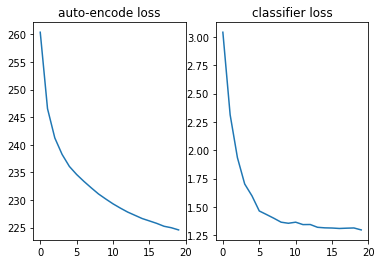

In [8]:
plt.subplot(121)
plt.plot(losses_auto_encode)
plt.title('auto-encode loss')
plt.legend()
plt.subplot(122)
plt.plot(losses_digit_classifier)
plt.title('classifier loss')
plt.legend()

In [9]:
def plot_samples(samples, fig_width=7):
    plt.figure(figsize=(fig_width, len(samples) * fig_width))
    samples = np.concatenate(samples)
    for i in xrange(len(samples)):
        plt.subplot(len(samples), num_digits, i + 1)
        plt.imshow(samples[i].reshape((28, 28)), cmap='Greys_r')
        plt.gca().xaxis.set_visible(False)
        plt.gca().yaxis.set_visible(False)

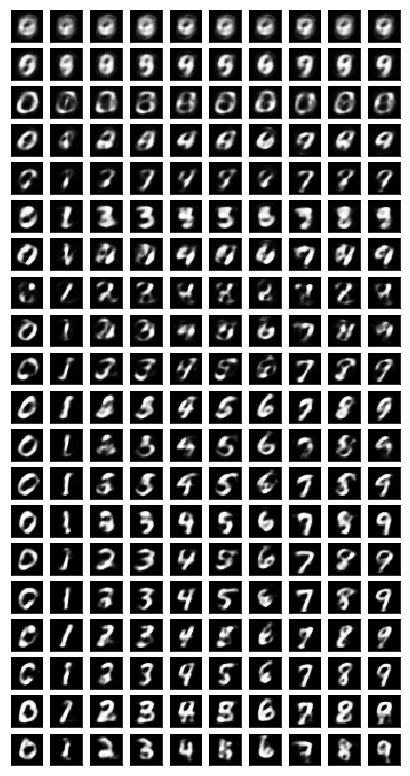

In [10]:
plot_samples(samples)